In [1]:
%matplotlib inline
import re
import string
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nltk.corpus import stopwords
from collections import Counter
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\megan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# reading in the original data from Kaggle
df = pd.read_csv('mbti_1.csv')
# separating our data by a delimintor: ||| 
df['seperated_post'] = df['posts'].apply(lambda x: x.strip().split("|||"))
df['num_post'] = df['seperated_post'].apply(lambda x: len(x))
# labeling each students with an identification variable
df['id'] = df.index
# converting our data frame from wide to long format with a unique ID variable
expanded_df = pd.DataFrame(df['seperated_post'].tolist(), index=df['id']).stack().reset_index(level=1, drop=True).reset_index(name='idposts')
# adding in the Personality type to the long format data frame
expanded_df=expanded_df.join(df.set_index('id'), on='id', how = 'left')
expanded_df=expanded_df.drop(columns=['posts','seperated_post','num_post'])
expanded_df.head()

,id,idposts,type
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw,INFJ
1,0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,INFJ
2,0,enfp and intj moments https://www.youtube.com...,INFJ
3,0,What has been the most life-changing experienc...,INFJ
4,0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,INFJ


In [3]:
# defining a function to remove hyperlinks, numbers, usernames, and punctuation
def clean_text(text):
    result = re.sub(r'http[^\s]*','link',text) # hyper links will be replaced with the word 'link'
    result = re.sub('[0-9]+','num', result).lower() # numbers will be replaced with the word 'num'
    result = re.sub('@[a-z0-9]+', 'user', result) # usernames are replaced with the word 'user'
    return re.sub('[%s]*' % string.punctuation,'',result) # punctuation are replaced with ''

In [4]:
# running the cleaning_text function on our data frame
final_df = expanded_df.copy()
final_df['idposts'] = final_df['idposts'].apply(clean_text)


In [5]:
final_df.head()

,id,idposts,type
0,0,link,INFJ
1,0,link,INFJ
2,0,enfp and intj moments link sportscenter not ...,INFJ
3,0,what has been the most lifechanging experience...,INFJ
4,0,link link on repeat for most of today,INFJ


In [6]:
# save our data to a csv file
final_df.to_csv("cleaned_data.csv", index=False)

In [7]:
#reading in our cleaned data
df = pd.read_csv("cleaned_data.csv")

print(df.shape)
df.head()

(422845, 3)


,id,idposts,type
0,0,link,INFJ
1,0,link,INFJ
2,0,enfp and intj moments link sportscenter not ...,INFJ
3,0,what has been the most lifechanging experience...,INFJ
4,0,link link on repeat for most of today,INFJ


<AxesSubplot:xlabel='index'>

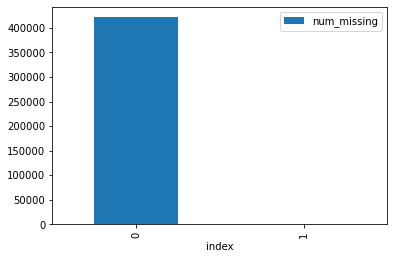

In [8]:
# first create missing indicator for features with missing data
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:  
#        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing


# then based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)
df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

In [9]:
# drop rows with a lot of missing values.
num = 0
ind_missing = df[df['num_missing'] > num].index
df_less_missing_rows = df.drop(ind_missing, axis=0)
df_less_missing_rows.shape

(421324, 5)

Number of comments per category

In [10]:
df_less_missing_rows.head()

,id,idposts,type,idposts_ismissing,num_missing
0,0,link,INFJ,False,0
1,0,link,INFJ,False,0
2,0,enfp and intj moments link sportscenter not ...,INFJ,False,0
3,0,what has been the most lifechanging experience...,INFJ,False,0
4,0,link link on repeat for most of today,INFJ,False,0


In [11]:
df2 = df_less_missing_rows.copy()

In [12]:
df2.drop(columns=['idposts_ismissing', 'num_missing'])
counts = []
typelist = []
for typeid,df_by_type in df2.groupby("type"):
    typelist.append(typeid)
    counts.append(df_by_type.shape[0])

df_stats = pd.DataFrame({"type":typelist,"counts":counts})

df_stats

,type,counts
0,ENFJ,9273
1,ENFP,32562
2,ENTJ,11219
3,ENTP,33515
4,ESFJ,2018
5,ESFP,2211
6,ESTJ,1915
7,ESTP,4322
8,INFJ,71868
9,INFP,89505


In [13]:
# load stopwords
stop_words = set(stopwords.words('english'))
#for word in ['im','dont','like','think','people','would','know','really','get','ive','one','time']:
for word in ['i','num', 'link','im','dont','like','think','people','really','ive','feel','much','want','say', 'always','also',
             'one','time','would','know','get','well','things','something','good','way','type','make','thats',
             'enfj','enfp','entj','entp','esfj','esfp','estj','estp','see','love','u','youre', 'even',
             'infj','infp','intj','intp','isfj','isfp','istj','istp','intjs','esfjs','enfjs','estjs']:
    stop_words.add(word)

In [14]:
## summarize the frequent words in each type
res = []
for typeid,type_df in df2.groupby("type"):
    sentence_list = type_df.idposts
    wordlist = []
    for sentence in sentence_list:
        for word in sentence.split():
            if word not in stop_words:
                wordlist.append(word)
    c = Counter(wordlist)
    print(typeid,[word for word,freq in c.most_common(3)])
#    print(typeid,c.most_common(10))
    for word,freq in c.most_common(3):
        res.append(word)

key_words_list = []

for x in res:
    if x not in key_words_list:
        key_words_list.append(x)

# key_words_list

columns_names = [col for col in key_words_list]
frames = [df2.drop(columns=['idposts_ismissing', 'num_missing']), 
          pd.DataFrame(0, index=df2.index, columns=columns_names)]
df_raw = df2.drop(columns=['idposts_ismissing','num_missing'])

ENFJ ['someone', 'friends', 'could']
ENFP ['lot', 'friends', 'could']
ENTJ ['find', 'someone', 'lot']
ENTP ['lot', 'go', 'could']
ESFJ ['lot', 'though', 'find']
ESFP ['lot', 'could', 'never']
ESTJ ['never', 'need', 'find']
ESTP ['go', 'sure', 'could']
INFJ ['life', 'someone', 'lot']
INFP ['lot', 'life', 'never']
INTJ ['could', 'someone', 'never']
INTP ['never', 'could', 'go']
ISFJ ['lot', 'though', 'sure']
ISFP ['lot', 'though', 'life']
ISTJ ['work', 'go', 'though']
ISTP ['go', 'never', 'lot']


In [15]:
# the list of key words that are distinguishable among each personality type
key_words_list

['someone',
 'friends',
 'could',
 'lot',
 'find',
 'go',
 'though',
 'never',
 'need',
 'sure',
 'life',
 'work']

In [16]:
# counting the number of times that a student mentions each key word where each row is a separate social media post
for word in key_words_list:
    df_raw[word] = df_raw.idposts.str.count(word)
df_raw.head(10)

,id,idposts,type,someone,friends,could,lot,find,go,though,never,need,sure,life,work
0,0,link,INFJ,0,0,0,0,0,0,0,0,0,0,0,0
1,0,link,INFJ,0,0,0,0,0,0,0,0,0,0,0,0
2,0,enfp and intj moments link sportscenter not ...,INFJ,0,0,0,0,0,0,0,0,0,0,0,0
3,0,what has been the most lifechanging experience...,INFJ,0,0,0,0,0,0,0,0,0,0,2,0
4,0,link link on repeat for most of today,INFJ,0,0,0,0,0,0,0,0,0,0,0,0
5,0,may the perc experience immerse you,INFJ,0,0,0,0,0,0,0,0,0,0,0,0
6,0,the last thing my infj friend posted on his fa...,INFJ,0,0,0,0,0,0,0,0,0,0,0,0
7,0,hello enfjnum sorry to hear of your distress i...,INFJ,0,0,0,0,0,0,0,0,0,0,0,0
8,0,num num link link,INFJ,0,0,0,0,0,0,0,0,0,0,0,0
9,0,welcome and stuff,INFJ,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
#count the number of times each person mentions the keywords in their 50 social media posts
wordcount=df_raw.groupby(['id', 'type']).sum()
wordcount=wordcount.add_suffix('').reset_index()
wordcount.head(10)

,id,type,someone,friends,could,lot,find,go,though,never,need,sure,life,work
0,0,INFJ,1,0,2,0,0,5,1,0,0,1,3,1
1,1,ENTP,1,4,0,0,2,6,3,4,2,1,1,3
2,2,INTP,2,1,3,0,2,12,2,2,0,0,1,4
3,3,INTJ,0,0,2,3,1,6,5,1,3,3,2,1
4,4,ENTJ,0,0,0,0,0,14,3,3,2,1,0,1
5,5,INTJ,4,0,6,4,2,22,9,2,4,0,1,2
6,6,INFJ,3,3,0,2,0,12,6,3,2,0,1,0
7,7,INTJ,1,2,1,1,0,7,12,0,1,3,2,2
8,8,INFJ,0,0,2,2,2,10,3,0,0,2,5,3
9,9,INTP,1,0,0,2,2,14,5,4,2,0,2,1


In [18]:
# Recoding the personality type of 
# Introverts ==1 and Extroverts ==0
wordcount['EI'] = wordcount['type'].str[0]
wordcount['EI']=np.where(wordcount['EI']=="I", 1,0)

# Recoding the personality type of 
# Sensing ==1 and iNtuition ==0
wordcount['SN'] = wordcount['type'].str[1]
wordcount['SN']=np.where(wordcount['SN']=="S", 1,0)

# Recoding the personality type of 
# Feeling ==1 and Thinking ==0
wordcount['FT'] = wordcount['type'].str[2]
wordcount['FT']=np.where(wordcount['FT']=="F", 1,0)

# Recoding the personality type of 
# Judging ==1 and Perceiving ==0
wordcount['JP'] = wordcount['type'].str[3]
wordcount['JP']=np.where(wordcount['JP']=="J", 1,0)
print(wordcount.shape)
wordcount.sample(n=10, random_state=2)



(8675, 18)


,id,type,someone,friends,could,lot,find,go,though,never,need,sure,life,work,EI,SN,FT,JP
1947,1947,INFJ,4,2,3,2,1,13,3,2,2,3,3,2,1,0,1,1
5716,5716,ISTJ,0,1,0,1,1,5,2,0,2,0,0,0,1,1,0,1
1445,1445,INFJ,1,0,1,5,3,6,3,5,0,4,0,1,1,0,1,1
1670,1670,INTJ,4,0,1,1,5,18,4,2,0,4,1,5,1,0,0,1
259,259,INTJ,1,1,1,1,4,5,2,1,2,0,1,0,1,0,0,1
8575,8575,ENTP,1,0,4,4,6,11,2,3,3,5,0,5,0,0,0,0
6036,6036,ENTP,0,0,2,3,1,9,2,0,3,5,1,0,0,0,0,0
6750,6750,ENTP,0,0,3,0,0,5,1,2,1,0,3,2,0,0,0,0
3535,3535,INFP,4,2,0,0,5,5,1,2,7,1,2,3,1,0,1,0
1861,1861,INFP,0,0,1,1,1,8,2,2,2,5,2,0,1,0,1,0


On Wednesday we can run Logistic regression where our input x variables will be the columns from the keyword list (ie. # of times each person says 'someone', 'friends', etc.) and our output variable, y, will be their personality type (E or I, S or N, F or T, J or P).


We can use a Logistic regression to compare the predicted personality type to their actual personality type and see how accurate our Logistic Regression model works using the frequencies of these keywords.

In [19]:
#labeling what I want to predict, y, (Extroversion) and 
# what I want to use as the input variable,x, (ie. Word Count)
X=wordcount.iloc[:,2:13]
X=X.values
y=wordcount.loc[:,'EI']
y=y.values


In [20]:
from sklearn.model_selection import train_test_split

# test train split
X_train,X_test,y_train,y_test = train_test_split(X, y,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y)

In [21]:
# check size of train and test arrays
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(6506, 11)
(2169, 11)
(6506,)
(2169,)


In [22]:
# run the logistic regression on the train data
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='multinomial')

log_reg.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial')

In [23]:
# then deploy the model on the test dataset to predict extroversion
preds = log_reg.predict(X_test)

In [24]:
# Classifications used in model
print('Binary Classification: \n',log_reg.classes_)
print()
# intercept of model b_0
print('Intercept: \n', log_reg.intercept_)
print()
# slope of the model b_1
print('Coefficients: \n',log_reg.coef_)

Binary Classification: 
 [0 1]

Intercept: 
 [0.61627607]

Coefficients: 
 [[ 0.01048312 -0.04542454 -0.0124467  -0.00072451  0.01946318 -0.0056233
   0.02031194  0.02392127 -0.02559359 -0.02575938  0.03698037]]


In [25]:
# checking model's performance.
# returns the matrix of probabilities that the predicted
# output is equal to zero (Extrovert) or one (Introvert)
log_reg.predict_proba(X_test)

array([[0.22158663, 0.77841337],
       [0.27447233, 0.72552767],
       [0.22247507, 0.77752493],
       ...,
       [0.27532318, 0.72467682],
       [0.15019435, 0.84980565],
       [0.31456783, 0.68543217]])

In [26]:
# Actual predictions based on the probability matrix
# on our test data
log_reg.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
# the accuracy of our model:
log_reg.score(X_test,y_test)

0.7699400645458737

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion matrx: \n', confusion_matrix(y_test, log_reg.predict(X_test)))
print()
print('Classification report: \n',classification_report(y_test, log_reg.predict(X_test)))

Confusion matrx: 
 [[   1  499]
 [   0 1669]]

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       500
           1       0.77      1.00      0.87      1669

    accuracy                           0.77      2169
   macro avg       0.88      0.50      0.44      2169
weighted avg       0.82      0.77      0.67      2169



In [29]:
#Create a confusion matrix
#y_test as first argument and the preds as second argument 
confusion_matrix(y_test, preds)

array([[   1,  499],
       [   0, 1669]], dtype=int64)

In [30]:
#transform confusion matrix into array
#the matrix is stored in a vaiable called confmtrx
confmtrx = np.array(confusion_matrix(y_test, preds))
#Create DataFrame from confmtrx array 
#rows for test: Male, Female, Infant designation as index 
#columns for preds: male, predicted_female, predicted_infant as column

pd.DataFrame(confmtrx, index=['Extroverts','Introverts'],
columns=['predicted_Extroverts', 'predicted_Introverts'])

,predicted_Extroverts,predicted_Introverts
Extroverts,1,499
Introverts,0,1669
